# Generating synthetic payments data

In this notebook, we'll build up a very simple simulator to generate payments data corresponding to legitimate and fraudulent transactions.  (There are many ways you could improve this generator and we'll call some of them out.)  We'll start by building up some functionality to run simulations in general.

## An (extremely) basic discrete-event simulation framework

The next function is all you need to run simple discrete-event simulations.  Here's how to use it:

- you'll define several streams of events, each of which is modeled by a Python generator,
- each event stream generator will `yield` a tuple consisting of *an offset* (the amount of time that has passed since the last event of that type) and *a result* (an arbitrary Python value associated with the event),
- the generator produced by the `simulate` function will yield the next event from all event streams indefinitely.

In [1]:
import heapq

def simulate(event_generators, initial_time=0):
    pq = []
    for event in event_generators:
        offset, result = next(event)
        heapq.heappush(pq, (offset + initial_time, result, event))
    
    while True:
        timestamp, result, event = heapq.heappop(pq)
        offset, next_result = next(event)
        heapq.heappush(pq, (timestamp + offset, next_result, event))
        yield (timestamp, result)

It may be easier to see how this works with an example.  In the next three cells, we 

1. define a generator for event streams, which samples interarrival times from a Poisson distribution and returns a predefined string as the result at each event,
2. set up a simulation with four streams, each of which has a different distribution of interarrival times and value, and
3. take the first twenty events from the simulation

In [2]:
from scipy import stats

def bedrockstream(mu, name):
    while True:
        offset, = stats.poisson.rvs(mu, size=1)
        yield (offset, name)

In [3]:
sim = simulate([bedrockstream(10, "fred"), 
                bedrockstream(12, "betty"), 
                bedrockstream(20, "wilma"), 
                bedrockstream(35, "barney")])

In [4]:
for i in range(20):
    print(next(sim))

(9, 'fred')
(12, 'betty')
(13, 'fred')
(22, 'betty')
(22, 'wilma')
(26, 'barney')
(30, 'betty')
(32, 'fred')
(40, 'betty')
(40, 'wilma')
(41, 'fred')
(48, 'fred')
(53, 'betty')
(60, 'fred')
(63, 'betty')
(65, 'wilma')
(69, 'barney')
(73, 'betty')
(76, 'fred')
(87, 'betty')


## Modeling transactions

The first problem we have to do is to decide what data we'll generate for each transaction.  Some interesting possibilities include:

- user ID
- merchant ID
- merchant type
- transaction amount (assuming a single currency)
- card entry mode (e.g., contactless, chip and pin, swipe, card manually keyed, or online transaction)
- foreign transaction (whether or not the user's home country matches the country in which the transaction is taking place)

We'll also generate a label for each transaction (`legitimate` or `fraud`).  We'll start with a very basic user event stream generator:  all of the transactions we generate will be legitimate, and we won't do anything particularly interesting with most of the fields.

In [5]:
import numpy as np
MERCHANT_COUNT = 20000

# a small percentage of merchants account for most transactions
COMMON_MERCHANT_COUNT = MERCHANT_COUNT // 21

common_merchants = np.random.choice(MERCHANT_COUNT, 
                                    size=COMMON_MERCHANT_COUNT, 
                                    replace=True)

def basic_user_stream(user_id, mu):
    favorite_merchants = np.random.choice(common_merchants,
                                         size=len(common_merchants) // 5)
    while True:
        amount = 100.00
        entry = "chip_and_pin"
        foreign = False
        
        merchant_id, = np.random.choice(favorite_merchants, size=1)
        offset, = stats.poisson.rvs(mu, size=1)
        result = {
            "user_id": user_id,
            "amount": amount,
            "merchant_id": merchant_id,
            "entry": entry,
            "foreign": foreign
        }
        yield (offset, ("legitimate", *result.values()))

In [6]:
sim = simulate([basic_user_stream(1, 700), basic_user_stream(2, 105), basic_user_stream(3, 40)])

In [7]:
for i in range(20):
    print(next(sim))

(43, ('legitimate', 3, 100.0, 12937, 'chip_and_pin', False))
(85, ('legitimate', 3, 100.0, 12531, 'chip_and_pin', False))
(104, ('legitimate', 2, 100.0, 9627, 'chip_and_pin', False))
(133, ('legitimate', 3, 100.0, 11515, 'chip_and_pin', False))
(176, ('legitimate', 3, 100.0, 3011, 'chip_and_pin', False))
(218, ('legitimate', 2, 100.0, 19708, 'chip_and_pin', False))
(221, ('legitimate', 3, 100.0, 17109, 'chip_and_pin', False))
(259, ('legitimate', 3, 100.0, 8559, 'chip_and_pin', False))
(310, ('legitimate', 3, 100.0, 842, 'chip_and_pin', False))
(323, ('legitimate', 2, 100.0, 18709, 'chip_and_pin', False))
(347, ('legitimate', 3, 100.0, 2361, 'chip_and_pin', False))
(396, ('legitimate', 3, 100.0, 2589, 'chip_and_pin', False))
(431, ('legitimate', 2, 100.0, 19497, 'chip_and_pin', False))
(435, ('legitimate', 3, 100.0, 11085, 'chip_and_pin', False))
(460, ('legitimate', 3, 100.0, 14329, 'chip_and_pin', False))
(498, ('legitimate', 3, 100.0, 16310, 'chip_and_pin', False))
(533, ('legitimat

## Exercise:  some quick improvements

1.  Users don't always just buy things from a few favorite merchants.  Change `basic_user_stream` so that they occasionally buy from any merchant.
2.  Most people buy many inexpensive things and relatively few expensive things.  Use this insight to generate (more) realistic transaction amounts.
3.  Some small percentage of online sales will be foreign transactions.  When a user is traveling abroad, nearly all of his or her transactions will be foreign transactions.  Add some state to `basic_user_stream` to model occasional international travel.

## Building a better transaction stream

We'll start by building a generator to build a mixture model we can use to make several kinds of transactions:  small, medium, and large.

In [8]:
def transaction_amounts(means, percentages, distribution=None):
    size = 256
    
    if distribution is None:
        distribution = lambda m, sz: stats.gamma.rvs(a=1.1, scale=min(m, 750), loc=m, size=sz)
    
    while True:
        streams = [distribution(m * 100, size) for m in means]
        stream = np.floor(np.choose(np.random.choice(len(means), p=percentages, size=size), streams)) / 100
        
        yield from stream

In [9]:
a = np.array([1.1,2.1,3.5])
np.floor(a)

array([1., 2., 3.])

Let's plot a histogram of some simulated transaction amounts sampled from three distributions with means corresponding to three kinds of purchases:  a latte, take-out for lunch, and a pair of Levi's.

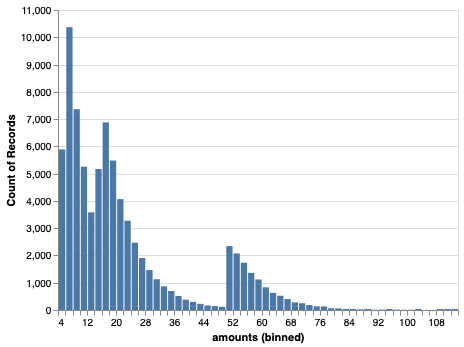

In [10]:
import pandas as pd

import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

amt = transaction_amounts([5, 15, 50], [0.5, 0.35, 0.15])
amounts = [next(amt) for i in range(80000)]

source = pd.DataFrame({"amounts": amounts})

alt.Chart(source).mark_bar().encode(
    alt.X("amounts", bin=alt.Bin(maxbins=100)),
    y='count()'
)

We can also plot a broader distribution of transactions:

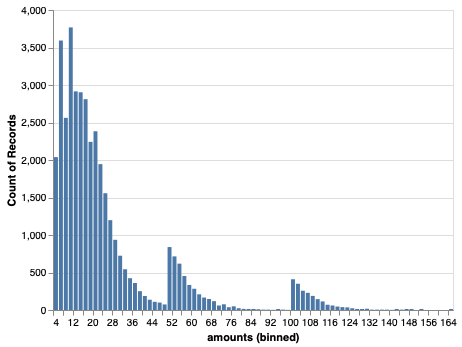

In [11]:
amt = transaction_amounts([5, 10, 15, 20, 50, 100], 
                          [0.35, 0.25, 0.15, 0.1, 0.1, 0.05])
amounts = [next(amt) for i in range(40000)]

source = pd.DataFrame({"amounts": amounts})

alt.Chart(source).mark_bar().encode(
    alt.X("amounts", bin=alt.Bin(maxbins=100)),
    y='count()',
)

Next up, we'll make a generator to create the entry types:

In [12]:
def legitimate_entry_types():
    size = 256
    
    entry_types = ["contactless", "chip_and_pin", "swipe", "manual", "online"]
    entry_probs = [0.25,0.2,0.15,0.05,0.35]

    while True:
        stream = [entry_types[i] for i in np.random.choice(len(entry_types), p=entry_probs, size=size)]
        yield from stream

...and one for selecting merchants (primarily a user's favorite merchants):

In [13]:
def merchant_stream(common_merchants, all_merchants, fav_percentage=0.2, probs=[0.6,0.37,0.03]):
    favorite_merchants = np.random.choice(common_merchants,
                                          size=int(len(common_merchants) * fav_percentage))
    merchants = [favorite_merchants, common_merchants, all_merchants]
    while True:
        pool = merchants[np.random.choice(len(merchants), p=probs)]
        yield int(np.random.choice(pool))

We can combine all of these to generate a stream of legitimate activity for a single user:

In [56]:
def legitimate_user_stream(user_id, transactions_per_day=12, amount_means=[20,100,500], amount_probs=[0.9,0.075,0.025]):
    amounts = transaction_amounts(amount_means, amount_probs)
    entry_types = legitimate_entry_types()
    merchants = merchant_stream(common_merchants, np.arange(MERCHANT_COUNT))
    
    SECONDS_PER_DAY = 86400
    loc = SECONDS_PER_DAY // transactions_per_day
    p = 1 / (loc / 10)

    while True:
        amount = next(amounts)
        entry = next(entry_types)
        foreign = entry == "online" and np.random.choice([True, False], p=[0.4, 0.6])
        
        merchant_id = next(merchants)
        offset, = stats.geom.rvs(p=p, loc=loc, size=1)
        result = {
            "user_id": user_id,
            "amount": amount,
            "merchant_id": merchant_id,
            "entry": entry,
            "foreign": foreign
        }
        yield (offset, ("legitimate", *result.values()))

In [57]:
sim = simulate([legitimate_user_stream(1), 
                legitimate_user_stream(2), 
                legitimate_user_stream(3)])

for i in range(200):
    print(next(sim))

(7408, ('legitimate', 1, 26.34, 13610, 'contactless', False))
(7417, ('legitimate', 2, 27.82, 1445, 'chip_and_pin', False))
(7895, ('legitimate', 3, 20.94, 1456, 'chip_and_pin', False))
(14735, ('legitimate', 1, 23.31, 514, 'contactless', False))
(15296, ('legitimate', 3, 103.68, 2930, 'contactless', False))
(15397, ('legitimate', 2, 24.56, 14863, 'online', True))
(22482, ('legitimate', 1, 24.43, 14887, 'online', False))
(23033, ('legitimate', 2, 20.01, 10007, 'contactless', False))
(23812, ('legitimate', 3, 106.4, 3699, 'contactless', False))
(30717, ('legitimate', 1, 37.06, 11025, 'online', False))
(32080, ('legitimate', 2, 23.45, 16013, 'manual', False))
(33635, ('legitimate', 3, 20.17, 16846, 'swipe', False))
(38367, ('legitimate', 1, 23.7, 5183, 'chip_and_pin', False))
(39723, ('legitimate', 2, 22.04, 16275, 'online', False))
(41180, ('legitimate', 3, 23.9, 5793, 'online', True))
(46503, ('legitimate', 1, 25.06, 10416, 'online', False))
(47127, ('legitimate', 2, 24.0, 6489, 'swipe

## Simulating fraud

We'll start with some basic assumptions:  

1. fraudulent transactions are equally likely to happen at any arbitrary merchant,
2. fraudulent transactions are typically for small dollar amounts,
3. fraudulent transactions are rare overall, but when they occur, several will occur close together,
4. fraudulent transactions are far more likely to be certain entry types (manual or online) or foreign transactions, and
5. fraudulent transactions occur without regard for the user's typical schedule.

These will guide the design of a fraudulent transaction generator.

WIP

In [ ]:
def fraud_entry_types():
    size = 256
    
    entry_types = ["contactless", "chip_and_pin", "swipe", "manual", "online"]
    entry_probs = [0.05,0.05,0.05,0.35,0.5]

    while True:
        stream = [entry_types[i] for i in np.random.choice(len(entry_types), p=entry_probs, size=size)]
        yield from stream

def fraudulent_user_stream(user_id, transactions_per_day=12, amount_means=[5,10,20], amount_probs=[0.2, 0.2, 0.6]):
    amounts = transaction_amounts(amount_means, amount_probs)
    entry_types = fraud_entry_types()
    
    SECONDS_PER_DAY = 86400
    loc = SECONDS_PER_DAY // transactions_per_day * 10
    p = 1 / (loc / 10)

    while True:
        fraud_delay, = np.floor(stats.gamma.rvs(a=6.4, loc=SECONDS_PER_DAY * 90, scale=SECONDS_PER_DAY, size=1))
        fraud_delay = int(fraud_delay)
        
        amount = next(amounts)
        entry = next(entry_types)
        foreign = np.random.choice([True, False], p=[0.4, 0.6])
        
        merchant_id = np.random.choice(MERCHANT_COUNT)
        offset, = stats.geom.rvs(p=p, loc=loc, size=1)
        result = {
            "user_id": user_id,
            "amount": amount,
            "merchant_id": merchant_id,
            "entry": entry,
            "foreign": foreign
        }
        yield (offset, ("legitimate", *result.values()))

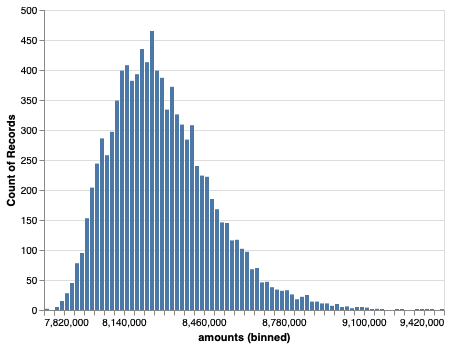

In [47]:
source = pd.DataFrame({"amounts": stats.gamma.rvs(a=6.4, loc=86400 * 90, scale=80000, size=10000)})

alt.Chart(source).mark_bar().encode(
    alt.X("amounts", bin=alt.Bin(maxbins=100)),
    y='count()'
)

In [50]:
sum([0.05,0.05,0.25,0.5,0.35])

1.2

In [53]:
np.random.choice([True, False], p=[0.3, 0.7])

False